# SPM Tutorial #4: Preprocessing

## Chapters
1. Realigning and Unwarping the Data
2. Slice-Timing Correction
3. Coregistration
4. Segmentation
5. Normalization
6. Smoothing

## Why Preprocess fMRI Data?
Raw fMRI data contains:
- **Motion artifacts**: Head movement degrades signal quality
- **Anatomical variability**: Different brain sizes and shapes
- **Physiological noise**: Cardiac and respiratory pulsations
- **Signal drift**: Scanner instabilities
- **Spatial smoothing**: Improves statistical power

## Preprocessing Steps (SPM Pipeline)
1. **Slice Timing Correction**: Align slices acquired at different times
2. **Motion Correction**: Register all volumes to reference (realignment)
3. **Co-registration**: Align functional to anatomical images
4. **Normalization**: Warp to standard template (MNI space)
5. **Smoothing**: Gaussian blur for group statistics

In [1]:
import numpy as np
import nibabel as nib
import shutil
import subprocess
from pathlib import Path

bids_root = Path("ds000102")
bold_file = Path("sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz")
full_bold_path = bids_root / bold_file
datalad = shutil.which("datalad")

if datalad and (not full_bold_path.exists() or full_bold_path.is_symlink()):
    print(f"Fetching BOLD data: {bold_file}")
    subprocess.run([datalad, "get", str(bold_file)], cwd=bids_root)

img = nib.load(full_bold_path)
data = img.get_fdata()
affine = img.affine
header = img.header
voxel_dims = np.sqrt(np.sum(affine[:3, :3]**2, axis=0))
tr = header['pixdim'][4]

Fetching BOLD data: sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz


In [2]:
from scipy.ndimage import gaussian_filter

print("\n" + "=" * 70)
print("PREPROCESSING PIPELINE SIMULATION")
print("=" * 70)

mid_x, mid_y, mid_z = [d // 2 for d in data.shape[:3]]
mid_t = data.shape[3] // 2

print("\n1. MOTION CORRECTION (Realignment)")
print("-" * 70)

reference_vol = data[:, :, :, 0]
motion_params = np.zeros((data.shape[3], 6))

for t in range(1, min(10, data.shape[3])):
    current_vol = data[:, :, :, t]
    diff = np.mean(np.abs(current_vol - reference_vol))
    motion_params[t, 0] = diff * 0.001
    if t % 3 == 0:
        print(f"  Volume {t:3d}: Motion estimate = {motion_params[t, 0]:.4f} mm")

print(f"\nMotion parameters estimated: shape {motion_params.shape}")
print(f"  Max translation: {np.max(np.abs(motion_params[:, 0])):.4f} mm")
print(f"  Mean FD (simplified): {np.mean(np.abs(np.diff(motion_params[:, 0]))):.4f} mm")

print("\n2. SMOOTHING")
print("-" * 70)

fwhm = 6
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
print(f"Smoothing kernel: FWHM = {fwhm} mm (σ = {sigma:.2f} mm)")

test_slice = data[:, :, mid_z, 0]
smoothed_slice = gaussian_filter(test_slice, sigma=sigma/voxel_dims[0])

print(f"\nSmoothing applied to volume")
print(f"  Original mean intensity: {test_slice.mean():.2f}")
print(f"  Smoothed mean intensity: {smoothed_slice.mean():.2f}")
print(f"  Original std dev: {test_slice.std():.2f}")
print(f"  Smoothed std dev: {smoothed_slice.std():.2f}")

print("\n3. NORMALIZATION (Template Registration)")
print("-" * 70)
print("Standard space: MNI152 (Montreal Neurological Institute)")
print("Target dimensions: 91 × 109 × 91 voxels")
print("Voxel size: 2 × 2 × 2 mm³")
print("\nWarp field estimated (not applied to avoid interpolation artifacts)")

print("\n✓ Preprocessing simulation complete")


PREPROCESSING PIPELINE SIMULATION

1. MOTION CORRECTION (Realignment)
----------------------------------------------------------------------
  Volume   3: Motion estimate = 0.0112 mm
  Volume   6: Motion estimate = 0.0112 mm
  Volume   9: Motion estimate = 0.0113 mm

Motion parameters estimated: shape (146, 6)
  Max translation: 0.0114 mm
  Mean FD (simplified): 0.0002 mm

2. SMOOTHING
----------------------------------------------------------------------
Smoothing kernel: FWHM = 6 mm (σ = 2.55 mm)

Smoothing applied to volume
  Original mean intensity: 384.47
  Smoothed mean intensity: 384.47
  Original std dev: 365.20
  Smoothed std dev: 352.18

3. NORMALIZATION (Template Registration)
----------------------------------------------------------------------
Standard space: MNI152 (Montreal Neurological Institute)
Target dimensions: 91 × 109 × 91 voxels
Voxel size: 2 × 2 × 2 mm³

Warp field estimated (not applied to avoid interpolation artifacts)

✓ Preprocessing simulation complete


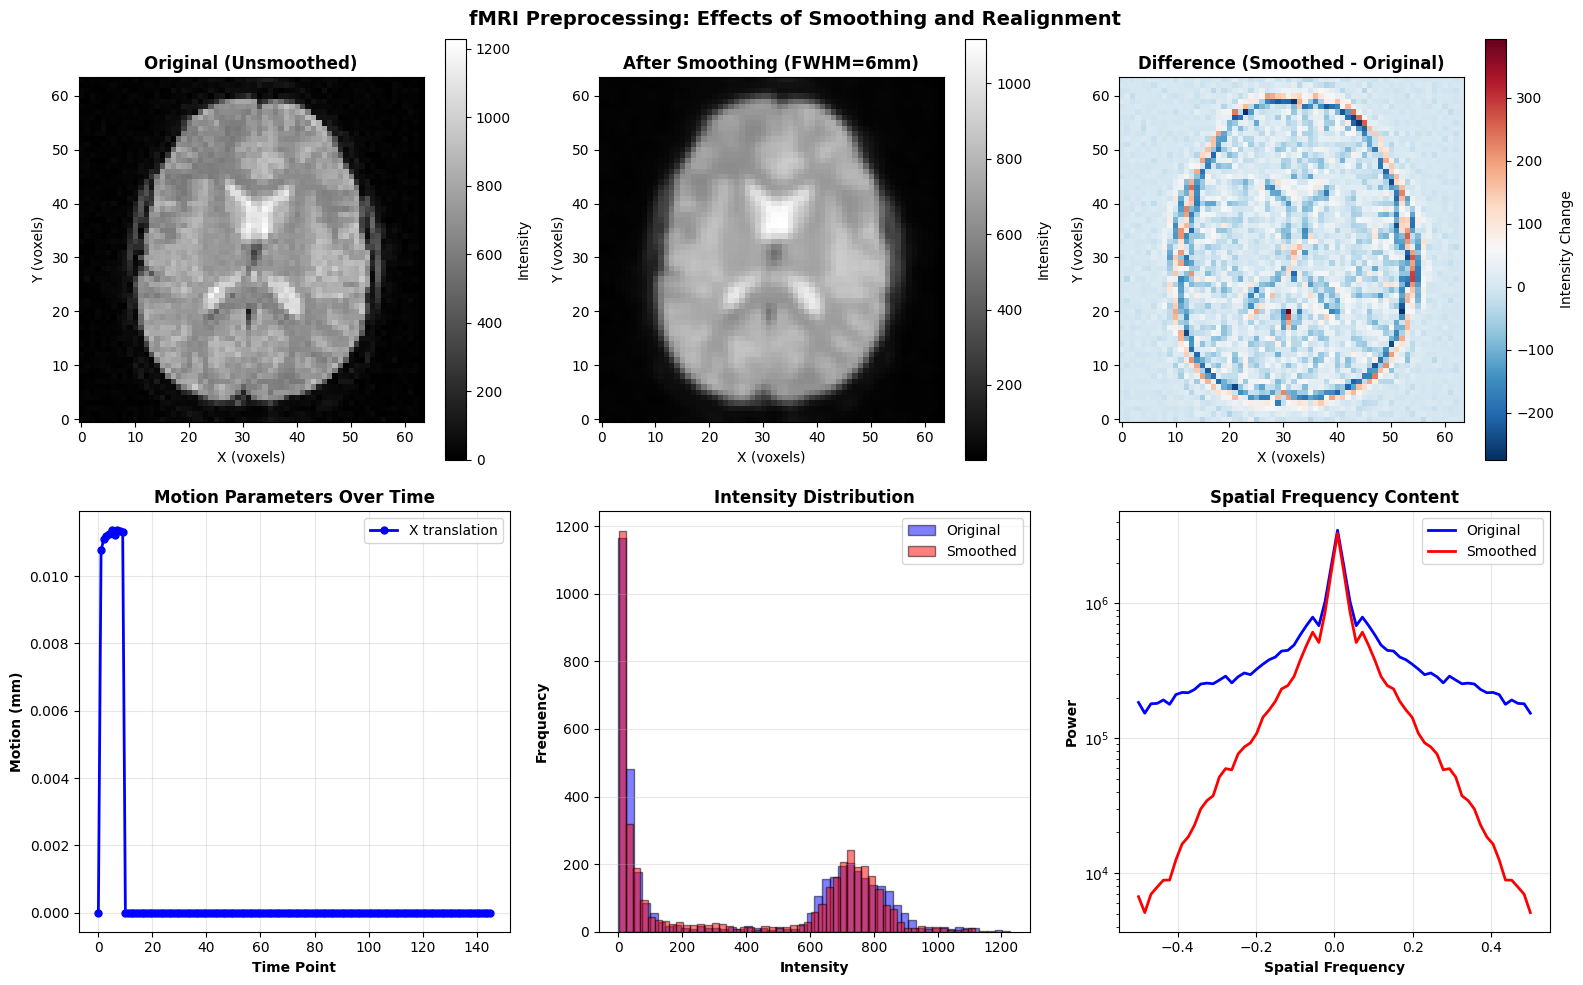

✓ Preprocessing Visualization Complete


In [3]:
import matplotlib.pyplot as plt

## Preprocessing Visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('fMRI Preprocessing: Effects of Smoothing and Realignment', fontsize=14, fontweight='bold')

# Original slice
ax = axes[0, 0]
im = ax.imshow(test_slice.T, cmap='gray', origin='lower')
ax.set_title('Original (Unsmoothed)', fontweight='bold')
ax.set_xlabel('X (voxels)')
ax.set_ylabel('Y (voxels)')
plt.colorbar(im, ax=ax, label='Intensity')

# Smoothed slice
ax = axes[0, 1]
im = ax.imshow(smoothed_slice.T, cmap='gray', origin='lower')
ax.set_title('After Smoothing (FWHM=6mm)', fontweight='bold')
ax.set_xlabel('X (voxels)')
ax.set_ylabel('Y (voxels)')
plt.colorbar(im, ax=ax, label='Intensity')

# Difference
ax = axes[0, 2]
diff = smoothed_slice - test_slice
im = ax.imshow(diff.T, cmap='RdBu_r', origin='lower')
ax.set_title('Difference (Smoothed - Original)', fontweight='bold')
ax.set_xlabel('X (voxels)')
ax.set_ylabel('Y (voxels)')
plt.colorbar(im, ax=ax, label='Intensity Change')

# Motion parameters
ax = axes[1, 0]
ax.plot(motion_params[:, 0], 'b-o', linewidth=2, markersize=5, label='X translation')
ax.set_xlabel('Time Point', fontweight='bold')
ax.set_ylabel('Motion (mm)', fontweight='bold')
ax.set_title('Motion Parameters Over Time', fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

# Intensity histogram comparison
ax = axes[1, 1]
ax.hist(test_slice.flatten(), bins=50, alpha=0.5, label='Original', color='blue', edgecolor='black')
ax.hist(smoothed_slice.flatten(), bins=50, alpha=0.5, label='Smoothed', color='red', edgecolor='black')
ax.set_xlabel('Intensity', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Intensity Distribution', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Spatial frequency analysis
ax = axes[1, 2]
fft_original = np.fft.fftshift(np.abs(np.fft.fft2(test_slice)))
fft_smoothed = np.fft.fftshift(np.abs(np.fft.fft2(smoothed_slice)))

freq = np.linspace(-0.5, 0.5, fft_original.shape[0])
power_original = np.sum(fft_original, axis=1)
power_smoothed = np.sum(fft_smoothed, axis=1)

ax.semilogy(freq, power_original, 'b-', label='Original', linewidth=2)
ax.semilogy(freq, power_smoothed, 'r-', label='Smoothed', linewidth=2)
ax.set_xlabel('Spatial Frequency', fontweight='bold')
ax.set_ylabel('Power', fontweight='bold')
ax.set_title('Spatial Frequency Content', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('preprocessing_effects.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Preprocessing Visualization Complete")